In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [3]:
def cal_undistort(img,gray, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

uploading images and generating chessboard corners

In [4]:

def get_imgpoints(image_names,objp):
    imgpoints=[]
    objpoints=[]
    gray=None
    for name in image_names:
    
        img=plt.imread(name)

        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
    return imgpoints,objpoints,gray
        

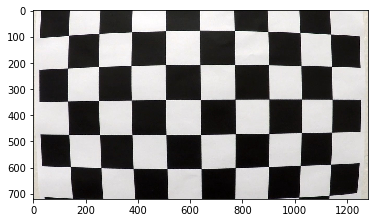

In [32]:


#folder_path="camera_cal"
image_names=glob.glob("camera_cal/*.jpg")
#print(image_names)
count=1
gray=None
objp=np.zeros((9*6,3),np.float32)
#print(objpoints)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
imgpoints,objpoints,gray=get_imgpoints(image_names,objp)
#print(objpoints)

plt.imshow(plt.imread(image_names[0]))

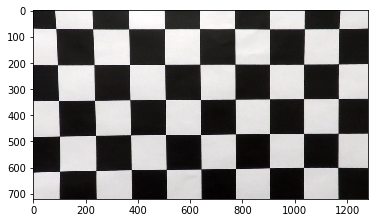

In [37]:
#loading images and undistort them 


fig.add_subplot(4,5,count)
count+=1
img=plt.imread(image_names[0])
undistorted = cal_undistort(img,gray, objpoints, imgpoints)
plt.imshow(undistorted)

# create a threshold binary image

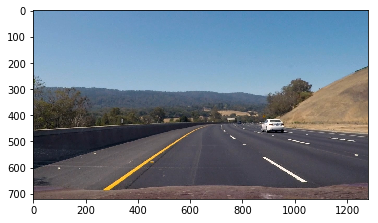

In [69]:
#laod test images
image_names=glob.glob("test_images/*.jpg")
img=plt.imread(image_names[4])
plt.imshow(img)

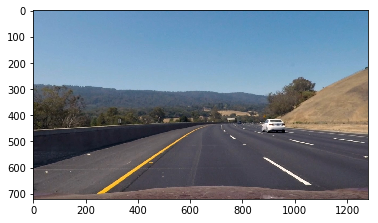

In [70]:
#undistort image
def undistort(img):
    objp=np.zeros((9*6,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    cal_img=plt.imread("camera_cal/calibration3.jpg")
    
    gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)
    
    undistorted=None
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret:
        imgpoints=[corners]
        objpoints=[objp]
        undistorted = cal_undistort(img,gray,objpoints, imgpoints)
    return undistorted
img=undistort(img)
plt.imshow(img)

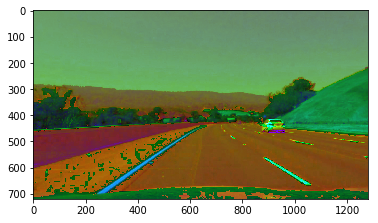

In [71]:
#HSL Color transform

hsl_img=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
plt.imshow(hsl_img)

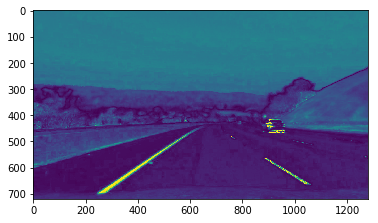

In [72]:
#get S channel
s_channel=hsl_img[:,:,2]
plt.imshow(s_channel)

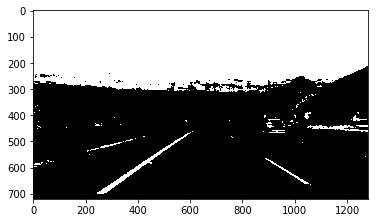

In [73]:
#coverting to binary
thresh = (90, 255)
b_img=np.zeros_like(s_channel)
b_img[(s_channel>=thresh[0])& (s_channel<=thresh[1])]=1
#print(b_img)
plt.imshow(b_img,cmap="gray")

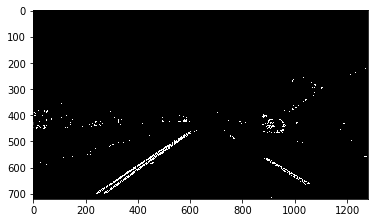

In [74]:
#applying sobel
sx_thresh=(20, 100)
sobel_x=cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobel_x) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

b_sobel_img=np.zeros_like(s_channel)
b_sobel_img[(scaled_sobel>=sx_thresh[0])& (scaled_sobel<=sx_thresh[1])]=1

plt.imshow(b_sobel_img,cmap=("gray"))


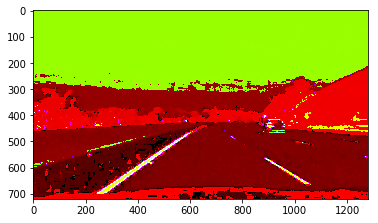

In [75]:
color_binary = np.dstack((hsl_img[:,:,0], b_img, b_sobel_img))*255 
plt.imshow(color_binary,cmap='gray')

(720, 1280)


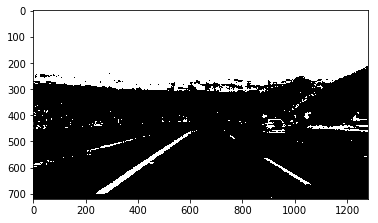

In [76]:
img_binary=np.zeros_like(s_channel)
img_binary[(b_img==1)|(b_sobel_img==1) ]=1
plt.imshow(img_binary,cmap='gray')
print(img_binary.shape)

In [77]:
print(img.shape)

(720, 1280, 3)


In [78]:
def draw_roi(img,src):
    x1,y1=src[0][0],src[0][1]
    x2,y2=src[1][0],src[1][1]
    x3,y3=src[2][0],src[2][1]
    x4,y4=src[3][0],src[3][1]
    
    cv2.line(img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(255,0,0),5)
    cv2.line(img,(src[1][0],src[1][1]),(src[2][0],src[2][1]),(255,0,0),5)
    cv2.line(img,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(255,0,0),5)
    cv2.line(img,(src[3][0],src[3][1]),(src[0][0],src[0][1]),(255,0,0),5)
    plt.imshow(img,cmap="gray")
    return img
    #print(x1,y1)

[[ 256.   720. ]
 [1113.6  720. ]
 [ 678.4  446.4]
 [ 601.6  446.4]]
[[320. 720.]
 [960. 720.]
 [960.   0.]
 [320.   0.]]


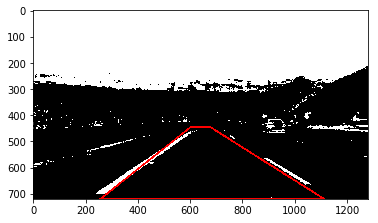

In [79]:
#transform image

src=np.float32([[100,img.shape[0]],[550,450],[750,450],[1180,img.shape[0]]])
dst=np.float32([[100,img.shape[0]],[50,-5000],[img.shape[1]-100,-5000],[img.shape[1]-100,img.shape[0]]])

rows,cols=img_binary.shape[:2]
bottom_left = [cols * 0.20, rows]
top_left = [cols * 0.47, rows * 0.62]
bottom_right = [cols * 0.87, rows]
top_right = [cols * 0.53, rows * 0.62]
src = np.float32([bottom_left, bottom_right, top_right, top_left])
dst = np.float32(
    [
        [cols * 0.25, rows],  # bottom_left
        [cols * 0.75, rows],  # bottom_right
        [cols * 0.75, rows * 0],  # top_right
        [cols * 0.25, rows * 0],  # top_left
    ])
print(src)
print(dst)
#print(np.int32(src))
stack_img=np.dstack((img_binary,img_binary,img_binary))* 255
img_color=draw_roi(stack_img,np.int32(src))


(720, 1280, 3)


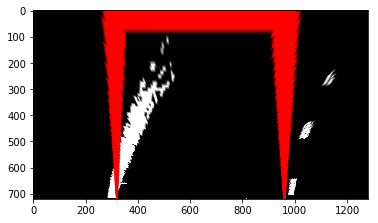

In [80]:


M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
img_size=(img.shape[1],img.shape[0])
warped = cv2.warpPerspective(img_color, M, img_size)
print(warped.shape)
plt.imshow(warped,cmap="gray")

# Applying histogram


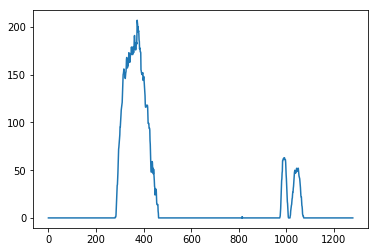

In [81]:
binary_warped= cv2.warpPerspective(img_binary, M, img_size)
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#plt.imshow(out_img)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    
    
    
     # Identify the nonze+
        
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
if leftx.any():
    left_fit = np.polyfit(lefty, leftx, 2)
if rightx.any():
    right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

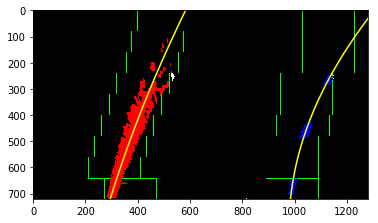

In [82]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
if leftx.any():
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
if rightx.any():
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
if leftx.any():
    plt.plot(left_fitx, ploty, color='yellow')
if rightx.any():
    plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

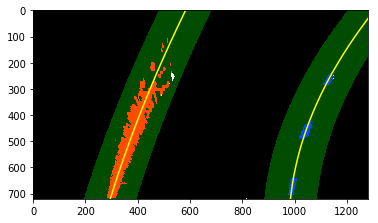

In [83]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

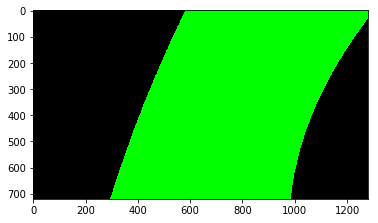

In [84]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

pts = np.hstack((pts_left, pts_right))
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
 # Draw the lane onto the warped blank image
full = cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
plt.imshow(full)

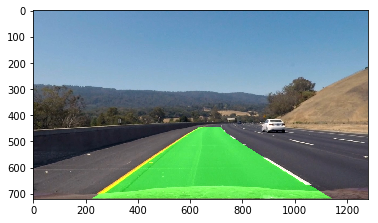

In [89]:
M = cv2.getPerspectiveTransform(dst, src)
        # Warp the image using OpenCV warpPerspective()
img_size=(img.shape[1],img.shape[0])
full = cv2.warpPerspective(full, M, img_size)
complete_img = cv2.addWeighted(img, 1.0, full, 0.6, 0.0)
plt.imshow(complete_img)